In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [122]:
magistrale= pd.DataFrame(pd.read_excel("iscritti_magistrale_informatica.xls")) 
triennale= pd.DataFrame(pd.read_excel("iscritti_triennale_informatica.xls")) 
piani= pd.DataFrame(pd.read_excel("piani_informatica.xls"))

In [123]:
triennale.head()

,PROGRESSIVO,GENERE,CODCLA,DECO_CLA,ANAC_LAUREA,VOTO_LAUREA,BASE_LAUREA,DATA_LAUREA,ANAC_INGRESSO,ANAC_USCITA,PERIODI_MOBILITA,SITUAZIONE_FINALE,ANAC_RINUNCIA,ANNO_DIPLOMA,MEDIA_DIPLOMA,BASE_DIPLOMA,DIPLOMA_LODE,TIPO_ISTITUTO,PROVINCIA_DIPLOMA,STATO_DIPLOMA
0,129859,M,8759,INFORMATICA,NaN,NaN,NaN,NaT,2010,2010,0,ATTIVO,NaN,1994,36.0,60.0,NaN,IST.TEC. IND. ST.,GENOVA,
1,132793,M,8759,INFORMATICA,NaN,NaN,NaN,NaT,2023,2023,0,ATTIVO,NaN,1994,44.0,60.0,NaN,IST.PROF.IND.ART.ST.,GENOVA,
2,148682,M,8759,INFORMATICA,2018.0,111.0,110.0,2019-07-24,2013,2018,0,ATTIVO,NaN,1996,36.0,60.0,NaN,LICEO SCIENT. ST.,GENOVA,ITALIA
3,158085,M,8759,INFORMATICA,NaN,NaN,NaN,NaT,2011,2011,0,ATTIVO,NaN,1996,50.0,60.0,NaN,LICEO SCIENT. ST.,SAVONA,ITALIA
4,190048,M,8759,INFORMATICA,NaN,NaN,NaN,NaT,2011,2011,0,ATTIVO,NaN,2002,100.0,100.0,NaN,LICEO CLASSICO ST.,GENOVA,


In [124]:
# magistrale: anno accademico ingresso: 2010-2023
print(magistrale['ANAC_INGRESSO'].unique())
# magistrale: anno accademico uscita: 2010-2023
print(magistrale['ANAC_USCITA'].unique())

# triennale: anno accademico ingresso: 2010-2023
print(triennale['ANAC_INGRESSO'].unique())
# triennale: anno accademico uscita: 2010-2023
print(triennale['ANAC_USCITA'].unique())

[2014 2012 2011 2013 2015 2017 2016 2020 2021 2018 2022 2019 2023 2010]
[2016 2012 2013 2014 2017 2018 2021 2023 2019 2022 2015 2020 2011 2010]
[2010 2023 2013 2011 2015 2020 2021 2018 2009 2012 2014 2019 2017 2016
 2022]
[2010 2023 2018 2011 2015 2020 2013 2009 2014 2016 2017 2012 2022 2021
 2019]


In [125]:
# percentuale donne in magistrale: 18.7
print((magistrale['GENERE'] == 'F').mean() * 100)

18.68686868686869


In [126]:
# percentuale donne in triennale: 14.4
print((triennale['GENERE'] == 'F').mean() * 100)

14.436363636363636


In [127]:
# valori unici per combinazione di colonne
#print(triennale[['CODCLA', 'DECO_CLA']].drop_duplicates())
#print()
#print(magistrale[['CODCLA', 'DECO_CLA']].drop_duplicates())

In [128]:
# join
pt = pd.merge(piani, 
              triennale[['PROGRESSIVO', 'CODCLA', 'GENERE', 'ANAC_INGRESSO']], 
              how="right", 
              left_on=["PROGRESSIVO", "CODCLA"], 
              right_on=["PROGRESSIVO", "CODCLA"])

In [129]:
# pulizia dati

# elimino in piani_triennali i valori in cui ho NaN in CODICE_INS e DECODIFICA_INS
pt.dropna(subset=['CODICE_INS', 'DECODIFICA_INS'], how='all', inplace=True)

# miglioro leggibilità
pt['CODCLA'] = pt['CODCLA'].astype(int)
pt['CODICE_INS'] = pt['CODICE_INS'].astype(int)
pt['VOTO'] = pt['VOTO'].astype(int)

# elimino colonna rindondante (codcla separa triennale e magistrale)
pt['CODCLA'].unique()
pt.drop(columns=['CODCLA'], inplace=True)

# elimino insegnamenti con meno di 50 partecipanti (molti a scelta con solo 1 persona)
pt = pt[pt.groupby('DECODIFICA_INS')['PROGRESSIVO'].transform('size') >= 50] # -- osservare cambiamenti al variare di min

# non ho voti inferiori al 18 -- notificare
#print(pt['VOTO'].min())

# elimino i voti maggiori di 32 - perchè non so cosa siano, per ora --notificare
pt = pt[pt['VOTO'] <= 32]

In [130]:
# per ogni esame passato percentuale di donne

# numero studenti
n_studenti = pt['PROGRESSIVO'].nunique()
# numero studenti per esame
n_studenti_per_esame = pt.groupby('DECODIFICA_INS').size()
# percentuale studenti per esame, su quelli nel database
perc = (n_studenti_per_esame / n_studenti) *100

n_donne_per_esame = pt[pt['GENERE'] == 'F'].groupby('DECODIFICA_INS').size()
#print(n_donne_per_esame)
perc_donne = ((n_donne_per_esame / n_studenti_per_esame) * 100)#.astype(int)
#print(perc_donne)

In [131]:
# esami potenzialmente discriminanti per le donne
# la percentuale di donne che hanno passato almeno un esame in triennale è 14.4

perc_donne_neg = perc_donne[perc_donne < (14.4)]
print(perc_donne_neg)

DECODIFICA_INS
ALGORITMI E STRUTTURE DATI                                  13.220676
ANALISI E PROGETTAZIONE DI ALGORITMI                        11.312217
APP MULTIMEDIALI E INTERNET OF THINGS                       13.772455
ARCHITETTURA DEI CALCOLATORI                                13.971292
BASI DI DATI                                                14.019851
CALCULUS 1                                                  14.097363
CALCULUS 2                                                  13.418530
COMPUTAZIONE QUANTISTICA                                     5.128205
ELEMENTI DI MATEMATICA E LOGICA                             14.203455
FONDAMENTI DELL'ELABORAZIONE DI SEGNALI E IMMAGINI          11.522634
FONDAMENTI DI INGEGNERIA DEL SOFTWARE                       12.811388
GEOMETRIA                                                   11.585366
INTRODUZIONE ALLA PROGRAMMAZIONE                            12.586873
LINGUA INGLESE 1                                            12.577833
LINGU

In [132]:
# esami potenzialmente discriminanti per gli uomini

perc_donne_pos = perc_donne[perc_donne >= (14.4)]
print(perc_donne_pos)

DECODIFICA_INS
ALGEBRA E LOGICA PER INFORMATICA                                     15.669516
ALGEBRA LINEARE E ANALISI NUMERICA                                   14.943960
BASI DI DATI 2                                                       16.250000
COMPLEMENTI DI ALGORITMI E STRUTTURE DATI (8 CFU)                    18.518519
COMPUTER SECURITY                                                    15.584416
CULTURA AZIENDALE                                                    15.151515
ELEMENTI DI CULTURA AZIENDALE, PROFESSIONALE, SOCIALE E GIURIDICA    17.557252
FONDAMENTI DELL'INFORMATICA                                          18.867925
FONDAMENTI DI COMPUTAZIONE QUANTISTICA                               14.482759
GESTIONE AZIENDALE                                                   18.548387
INFORMATICA PER CREATIVITÀ, DIDATTICA E DIVULGAZIONE                 24.719101
INGEGNERIA DEL SOFTWARE (6 CFU)                                      20.588235
INTRODUZIONE ALLA DATA SCIENCE       

In [133]:
# la percentuale del numero di voti delle donne
totale_voti = len(pt)  # non ci sono null #print(pt['CODICE_INS'].isnull().sum()) #print(pt['VOTO'].isnull().sum())
totale_voti_donne = len(pt[pt['GENERE'] == 'F']) 
(totale_voti_donne/totale_voti)*100 # percentuale di voti leggermente più bassa del numero di donne, posso assumere che si fermino prima degli uomini nel percorso?


13.846869909239004

In [134]:
# analizzo l'andamento generale dei voti per ogni esame (solo chi ha passato l'esame)
perc_voti = ((pt.groupby('VOTO').size()) / (totale_voti)) * 100

In [135]:
# analizzo l'andamento per le donne dei voti
perc_voti_donne = ((pt[pt['GENERE'] == 'F'].groupby('VOTO').size()) / (totale_voti_donne)) * 100

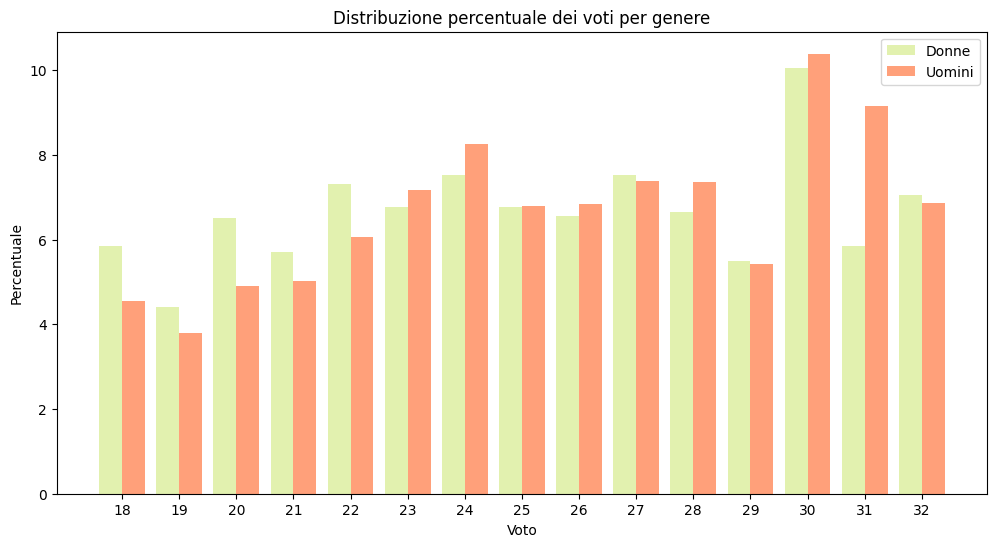

In [136]:
# visualizzazione della percentuale dei voti per genere

totale_voti_donne = len(pt[pt['GENERE'] == 'F'])
totale_voti_uomini = len(pt[pt['GENERE'] == 'M'])
voti_donne = pt[pt['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = pt[pt['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label='Donne', color='#E2F1AF')
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label='Uomini', color='#FFA07A')
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


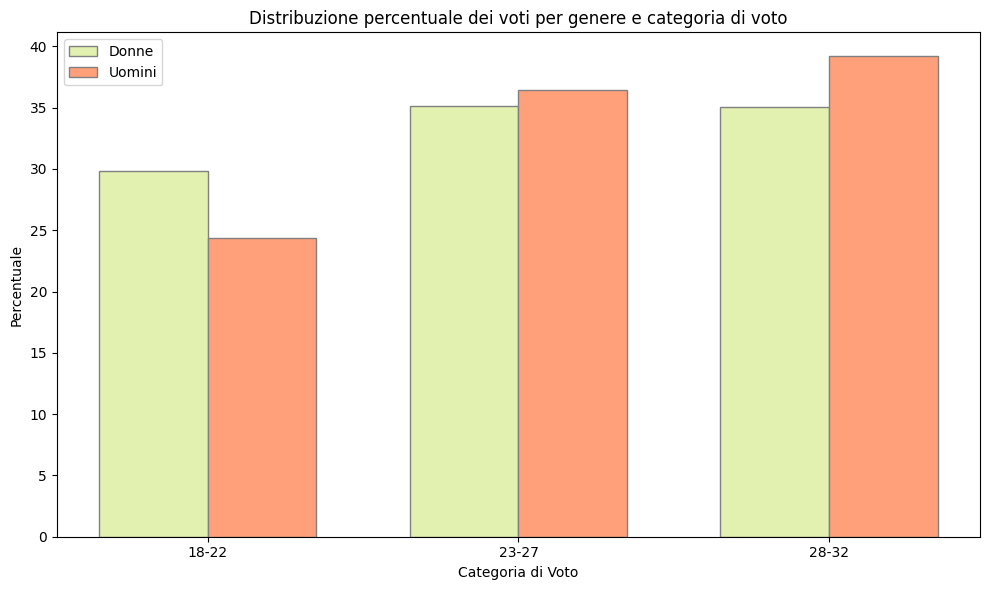

In [143]:
# visualizzazione raggruppata per range di voti

# categorie dei voti
categorie_voti = {
    '18-22': range(18, 23),
    '23-27': range(23, 28),
    '28-32': range(28, 33)
}

pt_donne = pt[pt['GENERE'] == 'F']
pt_uomini = pt[pt['GENERE'] == 'M']
totale_voti_donne = len(pt_donne)
totale_voti_uomini = len(pt_uomini)

# Funzione per calcolare percentuali di voti per categorie
def calcola_percentuali(pt_genere):
    conteggio_voti = pt_genere['VOTO'].value_counts().sort_index()
    percentuali = {}

    for categoria, intervallo in categorie_voti.items():
        conteggio_categoria = conteggio_voti.loc[intervallo].sum()
        percentuali[categoria] = (conteggio_categoria / len(pt_genere)) * 100

    return percentuali

# Calcolare percentuali per donne e uomini
percentuali_donne = calcola_percentuali(pt_donne)
percentuali_uomini = calcola_percentuali(pt_uomini)

# Creare il grafico a barre raggruppate
plt.figure(figsize=(10, 6))

bar_width = 0.35
r1 = np.arange(len(categorie_voti))
r2 = [x + bar_width for x in r1]

plt.bar(r1, list(percentuali_donne.values()), color='#E2F1AF', width=bar_width, edgecolor='grey', label='Donne')
plt.bar(r2, list(percentuali_uomini.values()), color='#FFA07A', width=bar_width, edgecolor='grey', label='Uomini')

plt.xlabel('Categoria di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e categoria di voto')
plt.xticks([r + bar_width/2 for r in range(len(categorie_voti))], categorie_voti.keys())
plt.legend()

plt.tight_layout()
plt.show()


In [138]:
# analizzo il numero di donne laureate

In [139]:
# analizzo il numero di donne laureate

In [140]:
# analizzo un periodo temporale preciso, il periodo di covid